# Complete Art Restoration Project using Deep Learning
Restore damaged artwork images using a U-Net based deep learning model.

In [2]:

!pip install -q opencv-python tensorflow keras matplotlib kaggle



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam


In [4]:
!pip install kaggle


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
import json

# Replace with actual credentials from kaggle.json
kaggle_token = {
    "username": "manishachaubey1",
    "key": "352823a4ee8e5c744b459b1d165dc3ba"
}

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_token, f)


## Step 1: Download and Extract Dataset

In [7]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Download the dataset and unzip
api.dataset_download_files("marcinrutecki/old-photos", path="old_photos", unzip=True)


Dataset URL: https://www.kaggle.com/datasets/marcinrutecki/old-photos


## Step 2: Define Damage Simulation

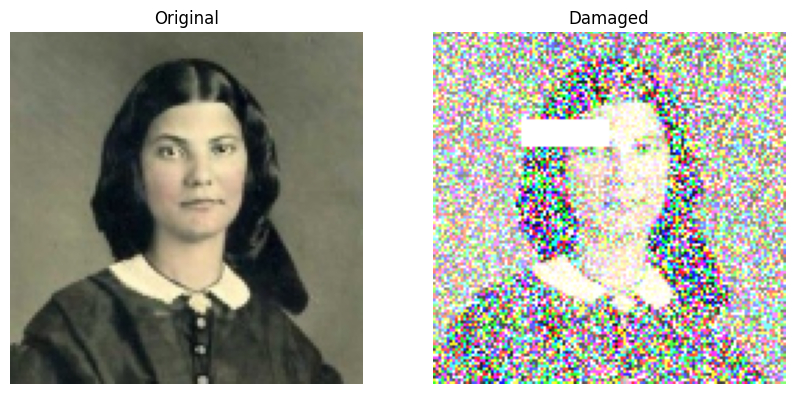

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

# Step 1: Define the damage function
def add_damage(image):
    damaged = image.copy()
    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    damaged = cv2.add(damaged, noise)
    h, w, _ = image.shape
    damaged[h//4:h//3, w//4:w//2] = 255  # white patch
    return damaged

# Step 2: Load a sample image
image_paths = glob("old_photos/*")
img = cv2.imread(image_paths[0])
img = cv2.resize(img, (128, 128))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Step 3: Apply damage
damaged_img = add_damage(img)

# Step 4: Visualize original vs damaged
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Damaged")
plt.imshow(damaged_img)
plt.axis('off')
plt.show()


## Step 3: Preprocess and Prepare Dataset

In [9]:

from glob import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# ✅ Adjust the path to match your folder name
image_paths = glob("old_photos/*")

images = []
damaged_images = []

# ✅ Load and process first 500 images (or fewer if needed)
for path in image_paths[:500]:
    img = cv2.imread(path)
    if img is None:
        continue
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img / 255.0)
    damaged_images.append(add_damage(img) / 255.0)

# ✅ Convert to NumPy arrays
images = np.array(images)
damaged_images = np.array(damaged_images)

# ✅ Split into training and validation
x_train, x_val, y_train, y_val = train_test_split(damaged_images, images, test_size=0.2)


## Step 4: Build U-Net Model

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam


In [11]:

def build_unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D()(c1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D()(c2)
    b = Conv2D(256, 3, activation='relu', padding='same')(p2)
    u1 = UpSampling2D()(b)
    m1 = concatenate([u1, c2])
    c3 = Conv2D(128, 3, activation='relu', padding='same')(m1)
    u2 = UpSampling2D()(c3)
    m2 = concatenate([u2, c1])
    c4 = Conv2D(64, 3, activation='relu', padding='same')(m2)
    outputs = Conv2D(3, 1, activation='sigmoid')(c4)
    return Model(inputs, outputs)

model = build_unet()
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 64)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 64, 64, 128)       │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 128)       │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 32, 32, 256)       │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 64, 64, 256)       │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 64, 64, 384)       │               0 │ up_sampling2d[0][0],       │
│                               │                           │                 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 128)       │         442,496 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_1               │ (None, 128, 128, 128)     │               0 │ conv2d_3[0][0]             │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 128, 128, 192)     │               0 │ up_sampling2d_1[0][0],     │
│                               │                           │                 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 128, 128, 64)      │         110,656 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 128, 128, 3)       │             195 │ conv2d_4[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 924,163 (3.53 MB)

 Trainable params: 924,163 (3.53 MB)

 Non-trainable params: 0 (0.00 B)

## Step 5: Train the Model

In [12]:

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=16)
model.save("art_restoration_model.h5")


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0749 - mae: 0.2347 - val_loss: 0.0497 - val_mae: 0.1855
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0670 - mae: 0.2229 - val_loss: 0.0455 - val_mae: 0.1773
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0667 - mae: 0.2238 - val_loss: 0.0433 - val_mae: 0.1724
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0640 - mae: 0.2189 - val_loss: 0.0416 - val_mae: 0.1686
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0627 - mae: 0.2168 - val_loss: 0.0399 - val_mae: 0.1651
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0584 - mae: 0.2079 - val_loss: 0.0380 - val_mae: 0.1605
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 997ms/step - loss: 0.0538 - mae: 0.1998 - val_loss: 0.0357 - val_mae: 0.1548
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0513 - mae: 0.1951 - val_loss: 0.0331 - val_mae: 0.1481
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0455 - mae: 0.1833 - val_lo

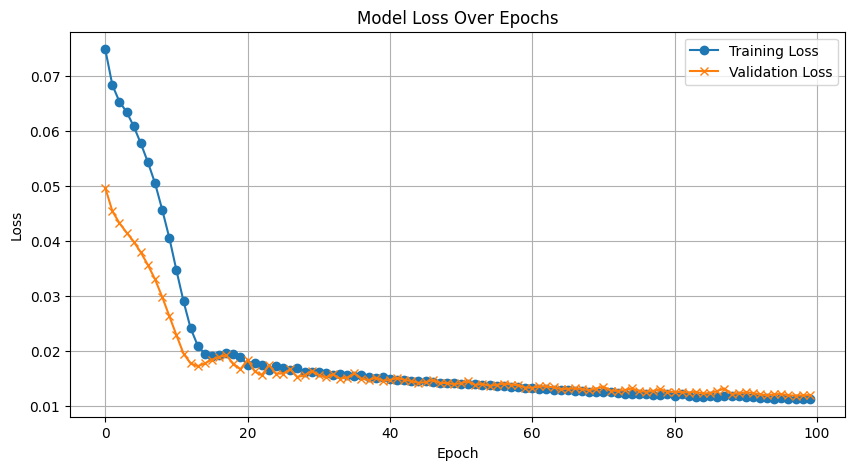

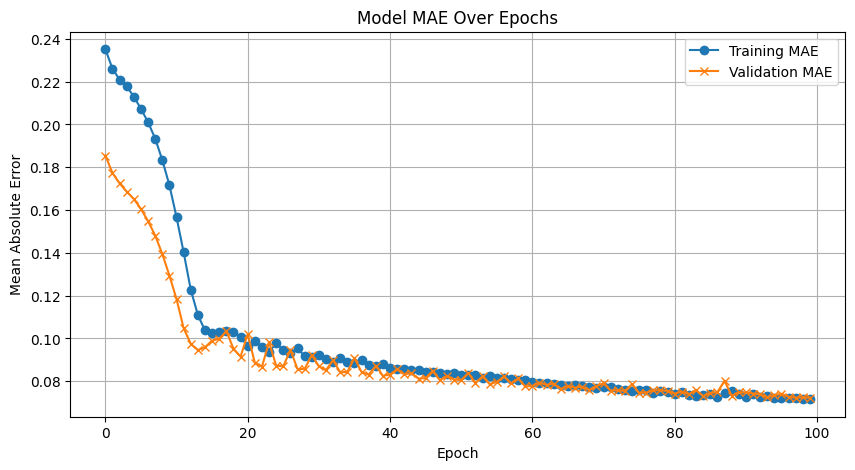

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE', marker='o')
plt.plot(history.history['val_mae'], label='Validation MAE', marker='x')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()


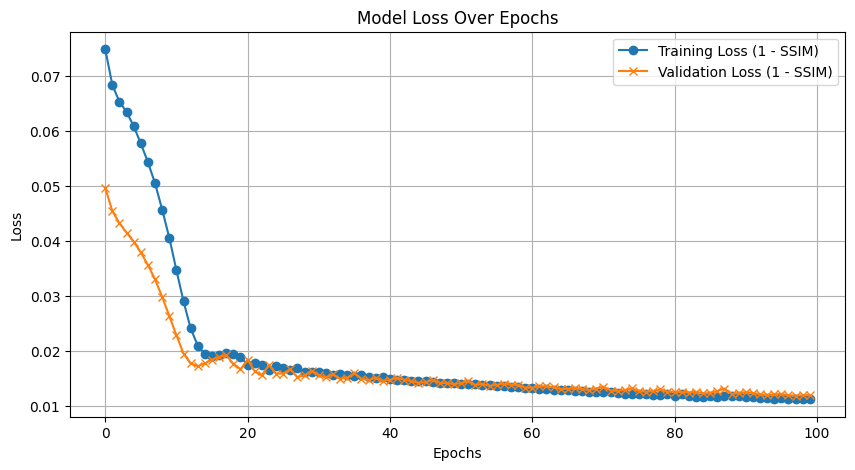

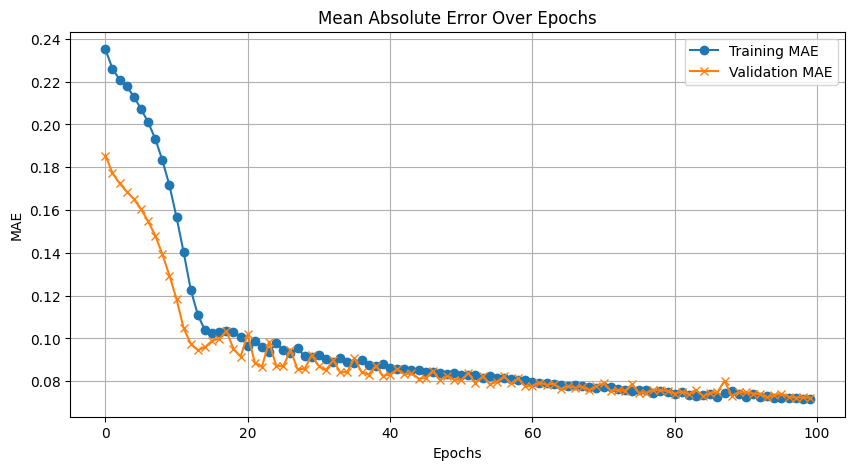

In [14]:
import matplotlib.pyplot as plt

# Plot Loss (SSIM-based)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss (1 - SSIM)', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss (1 - SSIM)', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE', marker='o')
plt.plot(history.history['val_mae'], label='Validation MAE', marker='x')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


## Step 6: Test and Visualize Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


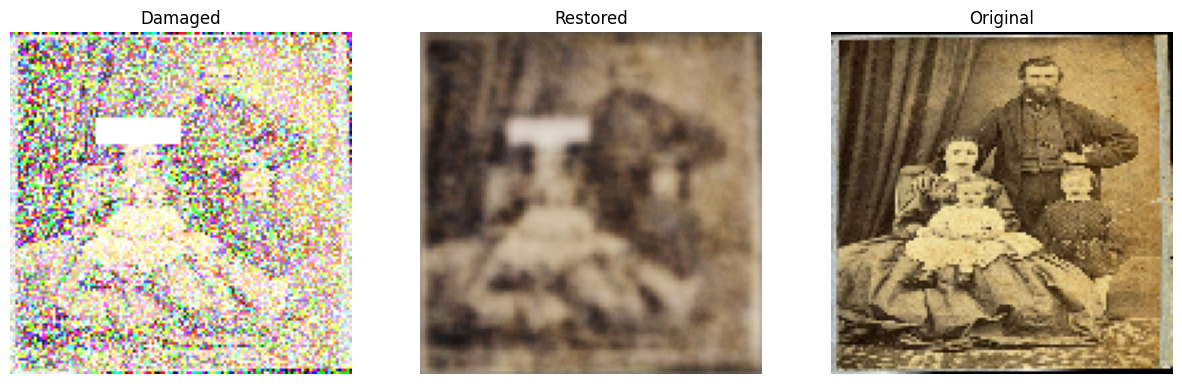

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


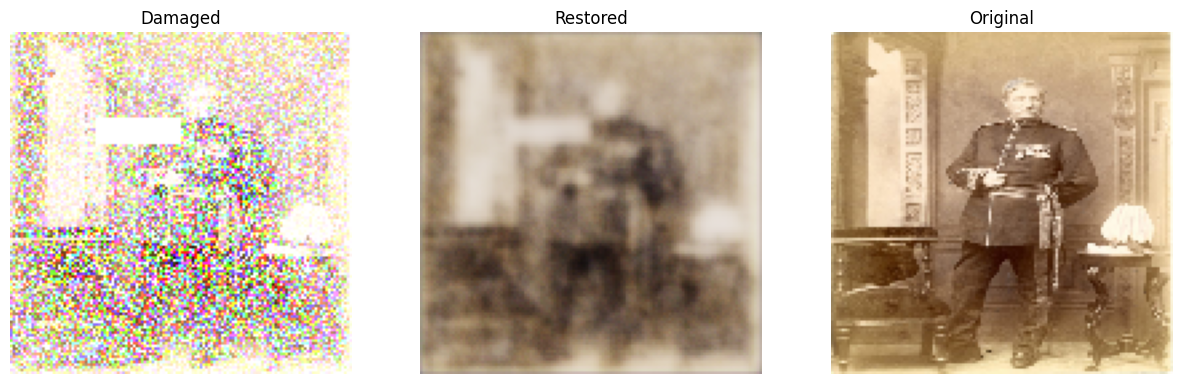

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


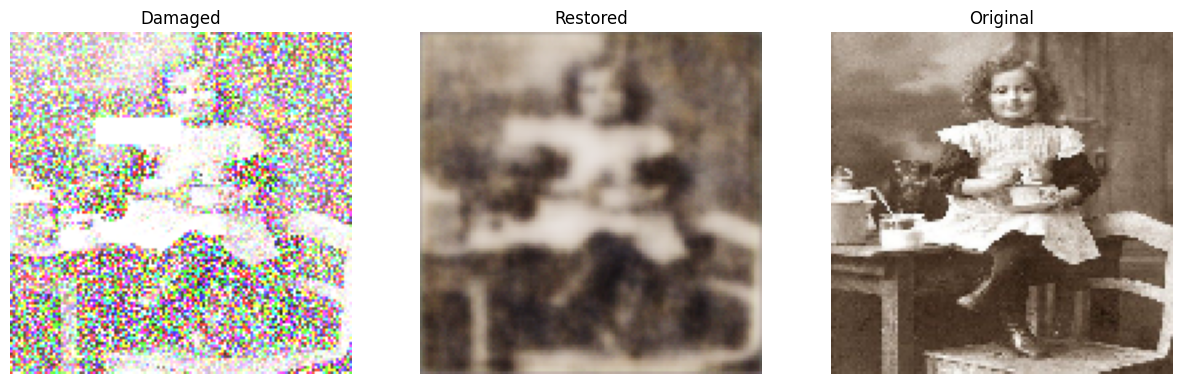

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


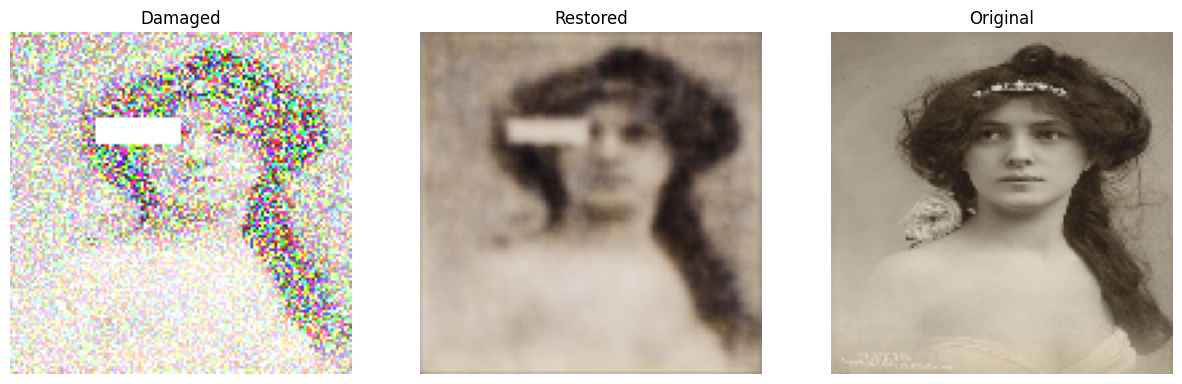

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


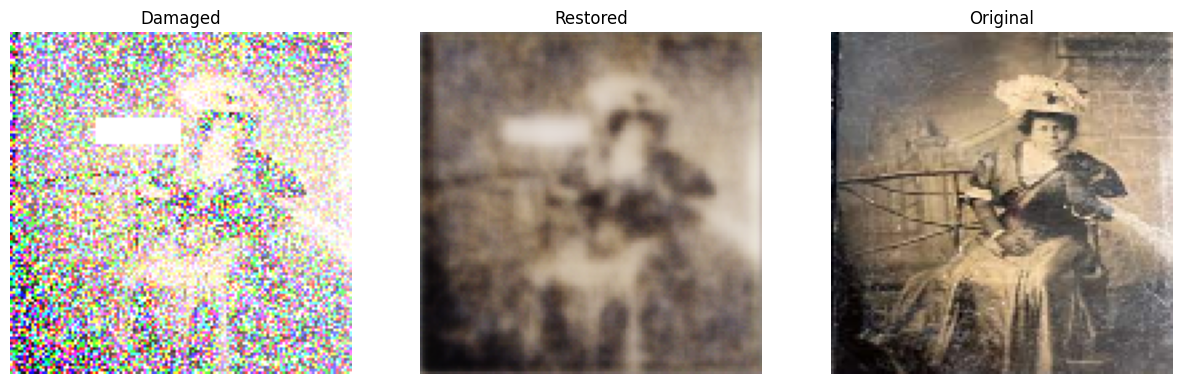

In [16]:
for i in range(5):
    sample = x_val[i]
    predicted = model.predict(np.expand_dims(sample, axis=0))[0]

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title("Damaged")
    plt.imshow(sample)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Restored")
    plt.imshow(predicted)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Original")
    plt.imshow(y_val[i])
    plt.axis('off')

    plt.show()


In [18]:
model.save("photo_restoration_model.keras")
